<a href="https://colab.research.google.com/github/adimyth/interesting_stuff/blob/master/tensorflow/mixed_data_input_regression_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tf-nightly-gpu-2.0-preview

In [0]:
!mkdir data

In [0]:
!git clone https://github.com/emanhamed/Houses-dataset data

In [1]:
!ls /content/data/Houses\ Dataset | wc -l

2141


## Imports

In [0]:
import locale
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
import tensorflow as tf
from tqdm import tqdm

## Constants

In [0]:
HEIGHT = 32
WIDTH = 32
DEPTH = 3
EPOCHS = 30
BATCH_SIZE = 8

In [0]:
cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
data = pd.read_csv('data/Houses Dataset/HousesInfo.txt', sep=' ', header=None, names=cols)

In [0]:
path = []
for i in data.index.values:
		path.append(os.path.sep.join(['data/Houses Dataset', "{}_frontal.jpg".format(i + 1)]))
data['image_path'] = path

In [0]:
path = []
for i in data.index.values:
  intermediate_paths = []
  for x in ['bathroom', 'bedroom', 'frontal', 'kitchen']:
    intermediate_paths.append(os.path.sep.join([f'data/Houses Dataset', "{0}_{1}.jpg".format(i + 1, x)]))
  path.append(intermediate_paths)
data['all_image_path'] = path

In [7]:
data.head()

,bedrooms,bathrooms,area,zipcode,price,image_path,all_image_path
0,4,4.0,4053,85255,869500,data/Houses Dataset/1_frontal.jpg,"[data/Houses Dataset/1_bathroom.jpg, data/Hous..."
1,4,3.0,3343,36372,865200,data/Houses Dataset/2_frontal.jpg,"[data/Houses Dataset/2_bathroom.jpg, data/Hous..."
2,3,4.0,3923,85266,889000,data/Houses Dataset/3_frontal.jpg,"[data/Houses Dataset/3_bathroom.jpg, data/Hous..."
3,5,5.0,4022,85262,910000,data/Houses Dataset/4_frontal.jpg,"[data/Houses Dataset/4_bathroom.jpg, data/Hous..."
4,3,4.0,4116,85266,971226,data/Houses Dataset/5_frontal.jpg,"[data/Houses Dataset/5_bathroom.jpg, data/Hous..."


In [0]:
# returns a tabular model without regression unit
def tabular_model(dim):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(8, input_dim=dim, activation="relu"))
  model.add(tf.keras.layers.Dense(4, activation="relu"))
  return model

In [0]:
# returns a cnn without regression unit
def cnn_model(width, height, depth, filters=(16, 32, 64), regress=False, activation=None):
  inputShape = (height, width, depth)
  inputs = tf.keras.layers.Input(shape=inputShape)
  x = inputs
  for (i, f) in enumerate(filters):      
    x = tf.keras.layers.Conv2D(f, (3, 3), padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(16)(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  x = tf.keras.layers.Dense(4)(x)
  x = tf.keras.layers.Activation("relu")(x)
  model = tf.keras.Model(inputs, x)
  return model

In [0]:
# this model trains on the concatenated input
def top_model(combined_input):
  x = tf.keras.layers.Dense(32, activation='relu')(combined_input)
  x = tf.keras.layers.Dense(16, activation='relu')(x)
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  return x

In [0]:
# returns numpy array of images for a single view (eg. frontal for all samples)
def load_images(data, field, height, width, depth):
  images = []
  for idx in tqdm(data.index.values):
    img = tf.io.read_file(data[field].iloc[idx])
    img = tf.image.decode_jpeg(img, channels=depth)
    img = tf.image.resize(img, [height, width])
    images.append(img)
  return np.array(images)

In [0]:
# helper function
def process_single_image(path, height, width, depth):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=depth)
  img = tf.image.resize(img, [height, width])
  return img

Scaling continous data & one-hot encoding categorical data

In [0]:
def treat_tab_data(data):
	continuous = ["bedrooms", "bathrooms", "area"]
	cs = MinMaxScaler()
	continous_data = cs.fit_transform(data[continuous])
 
	zipBinarizer = LabelBinarizer().fit(data["zipcode"])
	categorical_data = zipBinarizer.transform(data["zipcode"])
 
	data = np.hstack([continous_data, categorical_data]) 
	return data

Returns a `montage` for each sample with `bathroom, bedroom, frontal & kitchen` images stitched in a clock-wise manner

In [0]:
def load_image_montages(data, field, height, width, depth):
  images = []
  for idx in tqdm(data.index.values):
    image_paths = data[field].iloc[idx]
    intermediate_images = []
    for path in image_paths:
      img = process_single_image(path, height, width, depth)
      intermediate_images.append(img)
    
    outputImage = np.zeros((2*height, 2*width, depth), dtype="uint8")
    outputImage[0:height, 0:width] = intermediate_images[0]
    outputImage[0:height, width:2*width] = intermediate_images[1]
    outputImage[height:2*height, width:2*width] = intermediate_images[2]
    outputImage[height:2*height, 0:width] = intermediate_images[3]
    images.append(outputImage)
  return np.array(images)

In [0]:
def load_frontal_image(data, field, height, width, depth):
  images = []
  for idx in tqdm(data.index.values):
    img = process_single_image(data[field].iloc[idx], height, width, depth)
    images.append(img)
  return images

Given predictions & actual values, plots an image of actual house with predicted & actual prices

In [0]:
def plot_random_images(predictions, target, data):
  random_indices = np.random.randint(low=0, high=535, size=5)
  for idx in random_indices:
    plt.imshow(np.array(data[idx], np.int32))
    plt.title(f"Image:  {idx}\nActual: ${target.values[idx]}\nPredicted: ${np.round(predictions[idx][0], 2)}")
    plt.show()

In [17]:
tabular_data = data.copy()
images_data = load_images(data, 'image_path', HEIGHT, WIDTH, DEPTH)

100%|██████████| 535/535 [00:03<00:00, 148.28it/s]


In [18]:
images_montage_data = load_image_montages(tabular_data, 'all_image_path', HEIGHT, WIDTH, DEPTH)

100%|██████████| 535/535 [00:10<00:00, 52.09it/s]


In [19]:
plot_montage_data = load_image_montages(tabular_data, 'all_image_path', 256, 256, DEPTH)

100%|██████████| 535/535 [00:13<00:00, 39.26it/s]


In [0]:
target = tabular_data.price

In [0]:
tab_data = treat_tab_data(data)

## Mixed Input

### Tabular Data + Frontal Image Data

In [0]:
mlp = tabular_model(52)
cnn = cnn_model(WIDTH, HEIGHT, DEPTH)

In [0]:
combined_input = tf.keras.layers.concatenate([mlp.output, cnn.output])

In [0]:
output = top_model(combined_input) 

In [0]:
model = tf.keras.Model(inputs=[mlp.input, cnn.input], outputs=output)

In [0]:
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

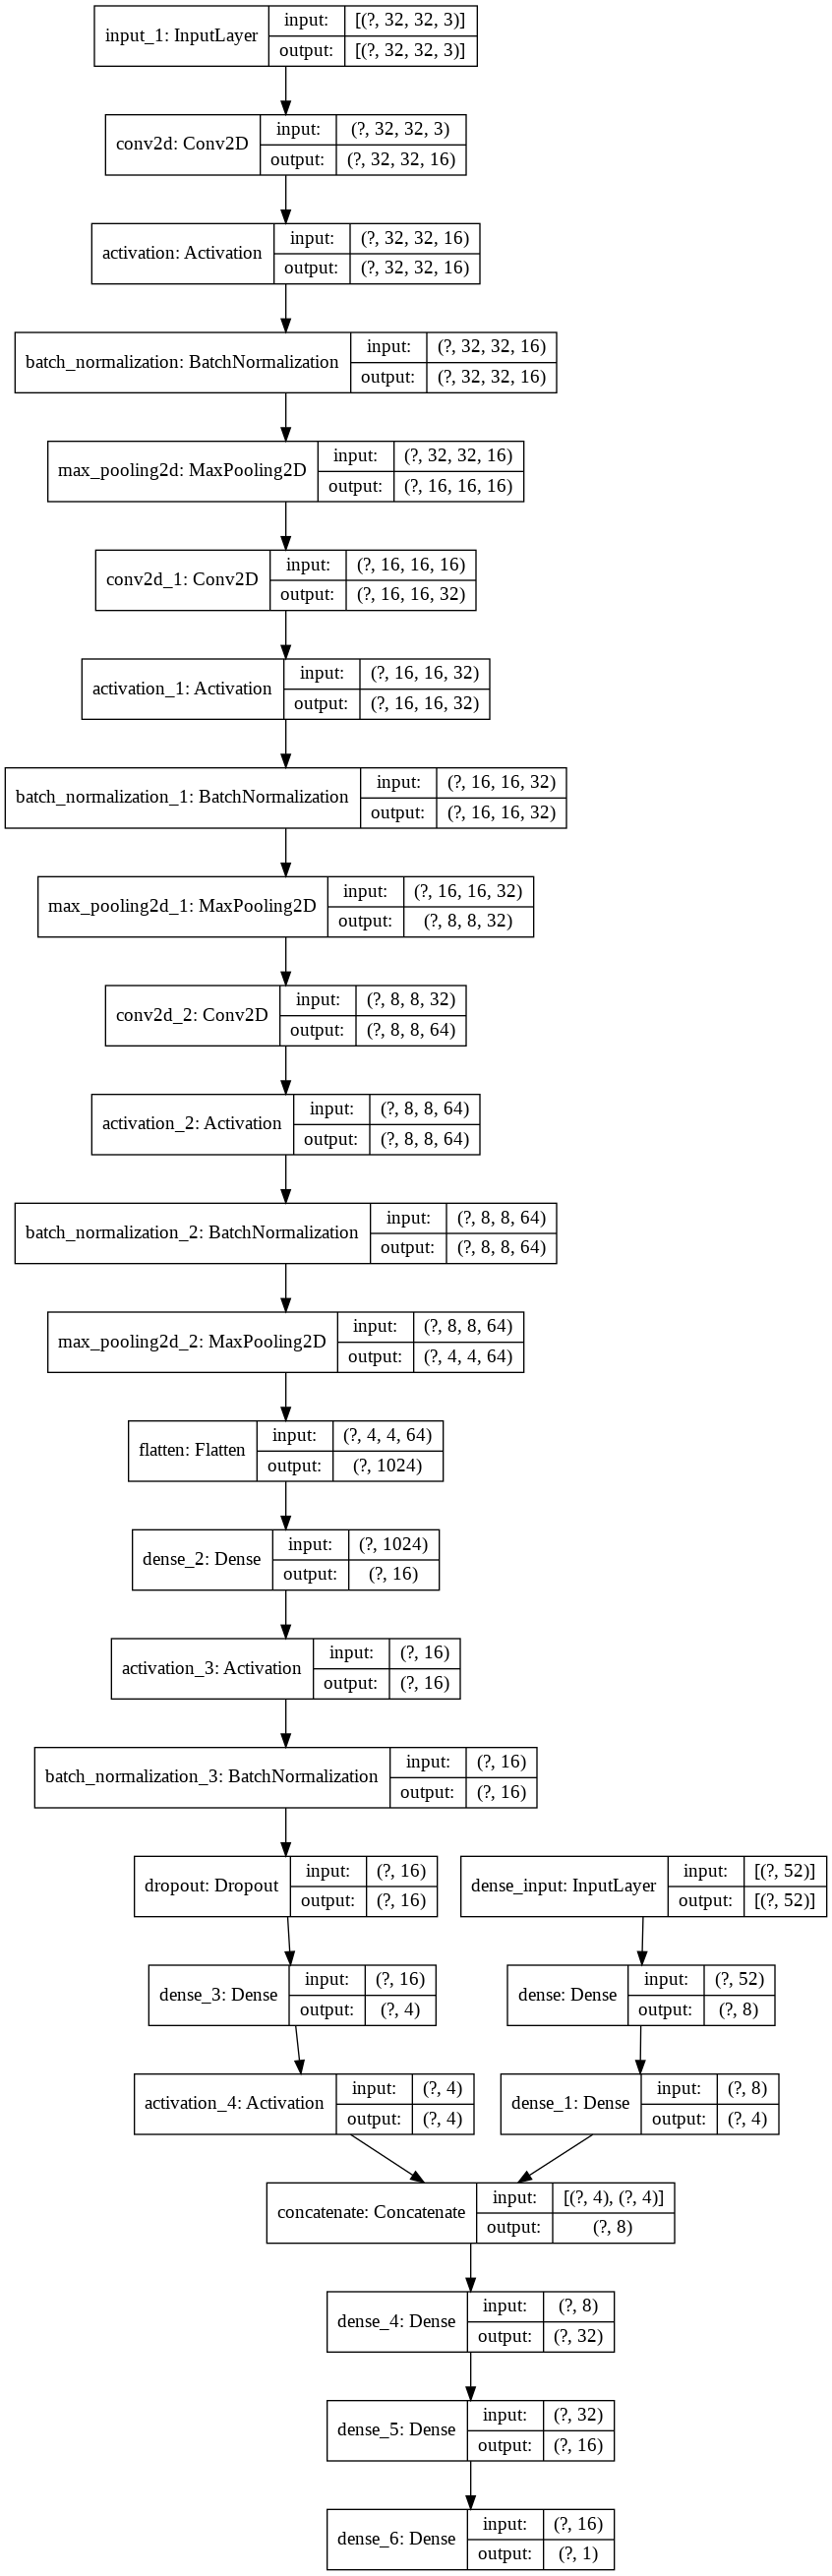

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
model.fit([tab_data, images_data], target.values/target.max(), epochs=EPOCHS, batch_size=BATCH_SIZE)

Train on 535 samples
Epoch 1/30
535/535 [==============================] - 3s 5ms/sample - loss: 527.4086
Epoch 2/30
535/535 [==============================] - 0s 688us/sample - loss: 127.8171
Epoch 3/30
535/535 [==============================] - 0s 701us/sample - loss: 84.5762
Epoch 4/30
535/535 [==============================] - 0s 728us/sample - loss: 83.7927
Epoch 5/30
535/535 [==============================] - 0s 667us/sample - loss: 80.9190
Epoch 6/30
535/535 [==============================] - 0s 679us/sample - loss: 75.4165
Epoch 7/30
535/535 [==============================] - 0s 643us/sample - loss: 68.5336
Epoch 8/30
535/535 [==============================] - 0s 665us/sample - loss: 57.4226
Epoch 9/30
535/535 [==============================] - 0s 702us/sample - loss: 47.6842
Epoch 10/30
535/535 [==============================] - 0s 631us/sample - loss: 38.5048
Epoch 11/30
535/535 [==============================] - 0s 704us/sample - loss: 32.6677
Epoch 12/30
535/535 [==========

In [0]:
preds = model.predict([tab_data, images_data])
predictions = preds*target.max()

In [33]:
frontal_data = load_frontal_image(data, 'image_path', 256, 256, DEPTH)

100%|██████████| 535/535 [00:03<00:00, 171.95it/s]


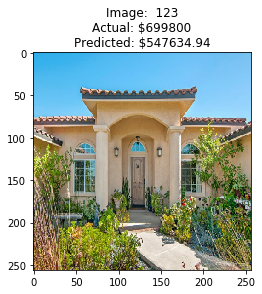

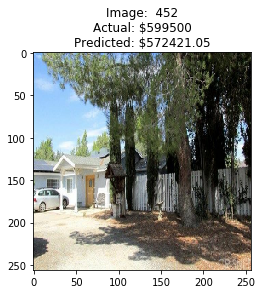

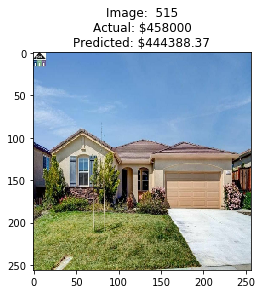

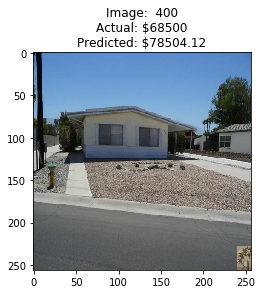

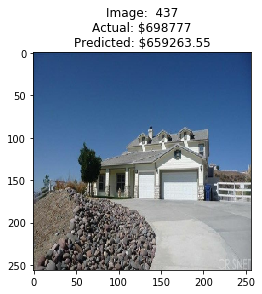

In [42]:
plot_random_images(predictions, target, frontal_data)

### Tabular Data + Montage Image Data

Training a model on the combination of tabular data & all 4 (bathroom, bedroom,  frontal, kitchen) images stitched together

In [0]:
mlp = tabular_model(52)
cnn = cnn_model(64, 64, DEPTH)

In [0]:
combined_input = tf.keras.layers.concatenate([mlp.output, cnn.output])

In [0]:
output = top_model(combined_input) 

In [0]:
model = tf.keras.Model(inputs=[mlp.input, cnn.input], outputs=output)

In [0]:
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

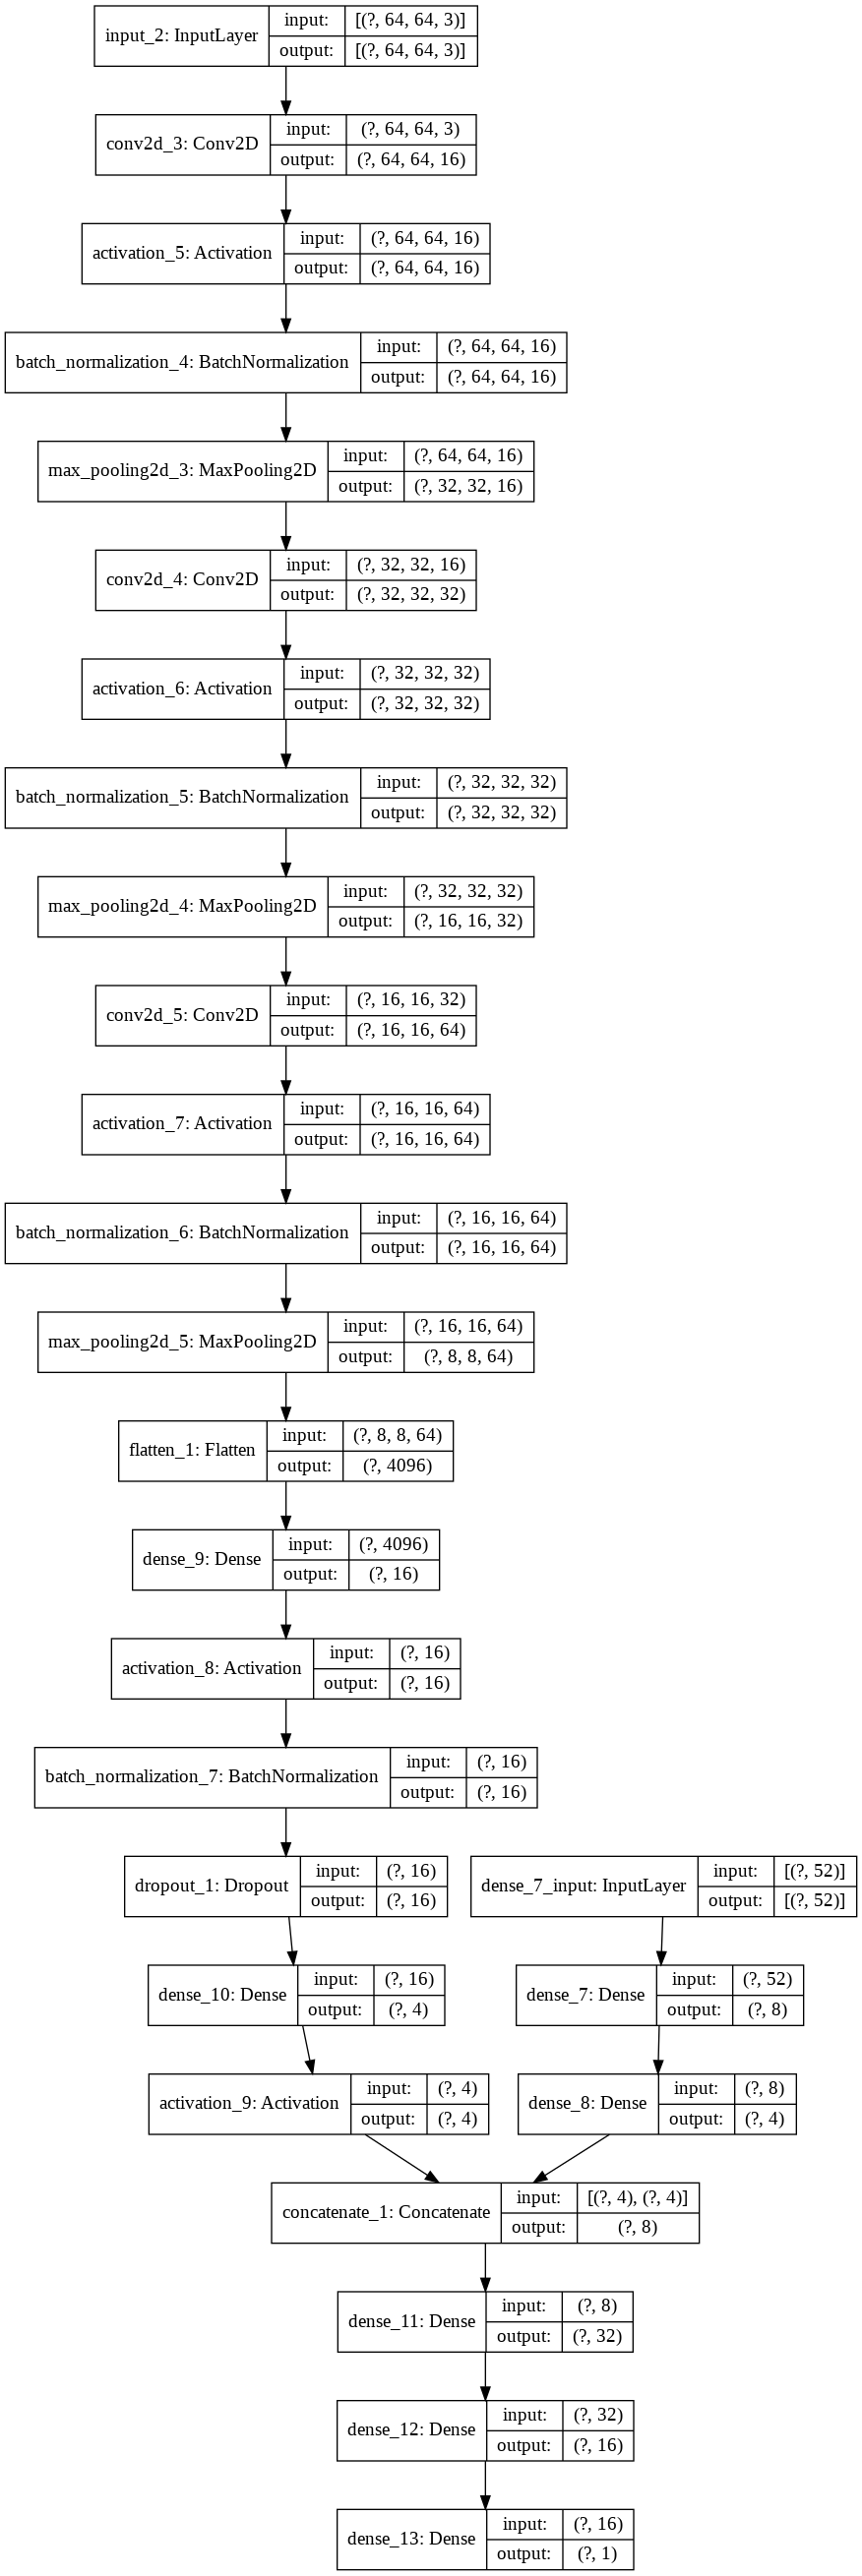

In [48]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [359]:
model.fit([tab_data, images_montage_data], target.values/target.max(), epochs=EPOCHS, batch_size=BATCH_SIZE)

Train on 535 samples
Epoch 1/30
535/535 [==============================] - 1s 2ms/sample - loss: 516.3367
Epoch 2/30
535/535 [==============================] - 0s 757us/sample - loss: 104.1822
Epoch 3/30
535/535 [==============================] - 0s 734us/sample - loss: 73.6365
Epoch 4/30
535/535 [==============================] - 0s 755us/sample - loss: 66.2150
Epoch 5/30
535/535 [==============================] - 0s 755us/sample - loss: 63.2242
Epoch 6/30
535/535 [==============================] - 0s 744us/sample - loss: 50.9918
Epoch 7/30
535/535 [==============================] - 0s 738us/sample - loss: 44.4139
Epoch 8/30
535/535 [==============================] - 0s 777us/sample - loss: 41.0513
Epoch 9/30
535/535 [==============================] - 0s 761us/sample - loss: 36.4424
Epoch 10/30
535/535 [==============================] - 0s 828us/sample - loss: 37.3952
Epoch 11/30
535/535 [==============================] - 0s 751us/sample - loss: 33.2673
Epoch 12/30
535/535 [==========

In [0]:
images_montage_data = images_montage_data.astype('float32')

In [0]:
preds = model.predict([tab_data, images_montage_data])
predictions = preds*target.max()

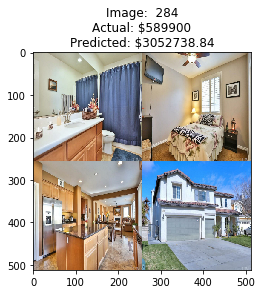

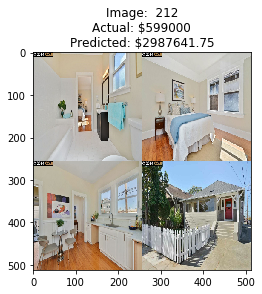

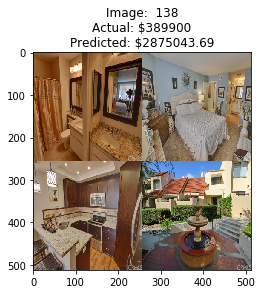

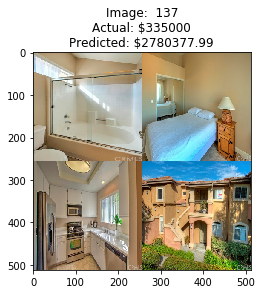

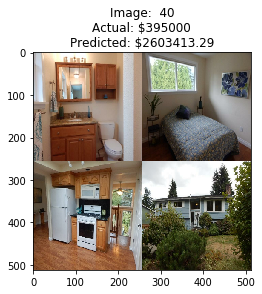

In [51]:
plot_random_images(predictions, target, plot_montage_data)

## Single Input

### Tabular Data Only

We are not performing any kind of preprocessing or transformation, such as normalization, scaling, etc

In [0]:
def get_tabular_model(dim):
  tab_model = tf.keras.Sequential()
  tab_model.add(tf.keras.layers.Dense(64, input_dim=dim, activation='relu'))
  tab_model.add(tf.keras.layers.Dense(32, activation='relu'))
  tab_model.add(tf.keras.layers.Dense(8, activation='relu'))
  tab_model.add(tf.keras.layers.Dense(1, activation='linear'))
  return tab_model

In [0]:
tabular_model = get_tabular_model(52)
tabular_model.compile(optimizer=opt, loss='mean_absolute_percentage_error')

In [57]:
tabular_model.fit(tab_data, tabular_data['price'].values/tabular_data['price'].max(), epochs=20)

Train on 535 samples
Epoch 1/20
535/535 [==============================] - 0s 612us/sample - loss: 134.1463
Epoch 2/20
535/535 [==============================] - 0s 88us/sample - loss: 53.6796
Epoch 3/20
535/535 [==============================] - 0s 90us/sample - loss: 41.4565
Epoch 4/20
535/535 [==============================] - 0s 80us/sample - loss: 31.9804
Epoch 5/20
535/535 [==============================] - 0s 85us/sample - loss: 30.7678
Epoch 6/20
535/535 [==============================] - 0s 77us/sample - loss: 29.0797
Epoch 7/20
535/535 [==============================] - 0s 84us/sample - loss: 30.2059
Epoch 8/20
535/535 [==============================] - 0s 80us/sample - loss: 29.7403
Epoch 9/20
535/535 [==============================] - 0s 84us/sample - loss: 26.9700
Epoch 10/20
535/535 [==============================] - 0s 84us/sample - loss: 25.5690
Epoch 11/20
535/535 [==============================] - 0s 81us/sample - loss: 24.9559
Epoch 12/20
535/535 [===================

### Image Data Only

In [0]:
def create_cnn(width, height, depth, regress=False, activation=None):
  inputShape = (height, width, depth)
  inputs = tf.keras.layers.Input(shape=inputShape)
  x = tf.keras.layers.Conv2D(16, (3, 3), padding="same")(inputs)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = tf.keras.layers.Conv2D(32, (3, 3), padding="same")(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = tf.keras.layers.Conv2D(64, (3, 3), padding="same")(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(16)(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  x = tf.keras.layers.Dense(4)(x)
  x = tf.keras.layers.Activation("relu")(x)

  if regress:
    if activation == None:
      x = tf.keras.layers.Dense(1, activation="linear")(x)
    else:
      x = tf.keras.layers.Dense(1, activation=activation)(x)

  model = tf.keras.Model(inputs, x)
  return model

#### Frontal View

In [0]:
cnn_model = create_cnn(HEIGHT, WIDTH, DEPTH, regress=True)
cnn_model.compile(optimizer=opt, loss='mean_absolute_percentage_error')

In [63]:
cnn_model.fit(images_data, tabular_data['price'].values/tabular_data['price'].max(), epochs=EPOCHS)

Train on 535 samples
Epoch 1/30
535/535 [==============================] - 0s 199us/sample - loss: 51.7953
Epoch 2/30
535/535 [==============================] - 0s 173us/sample - loss: 55.6876
Epoch 3/30
535/535 [==============================] - 0s 182us/sample - loss: 52.2720
Epoch 4/30
535/535 [==============================] - 0s 192us/sample - loss: 52.0931
Epoch 5/30
535/535 [==============================] - 0s 176us/sample - loss: 51.7930
Epoch 6/30
535/535 [==============================] - 0s 185us/sample - loss: 49.8455
Epoch 7/30
535/535 [==============================] - 0s 172us/sample - loss: 54.2964
Epoch 8/30
535/535 [==============================] - 0s 173us/sample - loss: 52.5130
Epoch 9/30
535/535 [==============================] - 0s 165us/sample - loss: 49.8034
Epoch 10/30
535/535 [==============================] - 0s 190us/sample - loss: 48.8687
Epoch 11/30
535/535 [==============================] - 0s 200us/sample - loss: 48.1934
Epoch 12/30
535/535 [==========

**CNN model when given only `Frontal` image view struggles, as compared to the previous results**

#### All Views

In [0]:
cnn_model = create_cnn(64, 64, 3, regress=True, activation='sigmoid')
cnn_model.compile(optimizer=opt, loss='mean_absolute_percentage_error')

In [68]:
cnn_model.fit(images_montage_data, tabular_data['price'].values/tabular_data['price'].max(), epochs=EPOCHS)

Train on 535 samples
Epoch 1/30
535/535 [==============================] - 1s 2ms/sample - loss: 557.4640
Epoch 2/30
535/535 [==============================] - 0s 247us/sample - loss: 268.2084
Epoch 3/30
535/535 [==============================] - 0s 248us/sample - loss: 146.7517
Epoch 4/30
535/535 [==============================] - 0s 238us/sample - loss: 111.4054
Epoch 5/30
535/535 [==============================] - 0s 241us/sample - loss: 97.6078
Epoch 6/30
535/535 [==============================] - 0s 259us/sample - loss: 101.8100
Epoch 7/30
535/535 [==============================] - 0s 243us/sample - loss: 87.8417
Epoch 8/30
535/535 [==============================] - 0s 244us/sample - loss: 81.4390
Epoch 9/30
535/535 [==============================] - 0s 233us/sample - loss: 79.6925
Epoch 10/30
535/535 [==============================] - 0s 233us/sample - loss: 73.7780
Epoch 11/30
535/535 [==============================] - 0s 240us/sample - loss: 74.1783
Epoch 12/30
535/535 [=======

In [0]:
preds = cnn_model.predict(images_montage_data)
predictions = preds*tabular_data['price'].max()

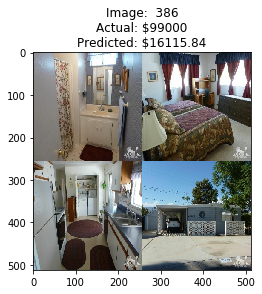

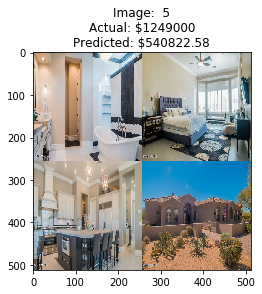

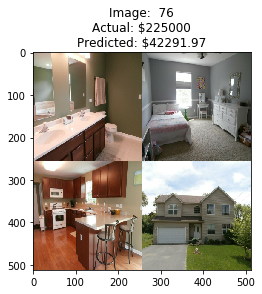

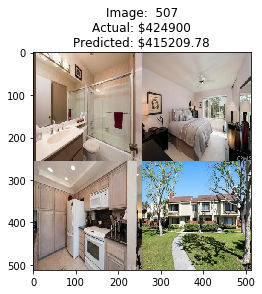

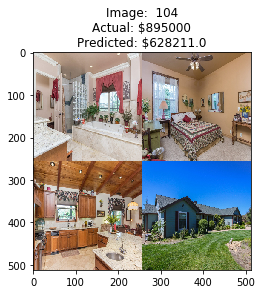

In [74]:
plot_random_images(predictions, target, plot_montage_data)